In [1]:
import numpy as np
import matplotlib.pyplot as plt
import neuron
from neuron import h

h.load_file('stdrun.hoc')
neuron.load_mechanisms('mechanisms')
h.load_file('templates/templates.hoc') # reads in template

h.dt = 0.05 # time step (resolution) of the simulation in ms
h.steps_per_ms = 1 / h.dt
h.celsius = 36.0

### Setup

In [2]:
"""
initW estimated from intrinsic excitatory connections
CP: 1.2, CS: 0.6, FSI: 0.5, LTS: 0.1
"""

cell_type_settings = {
    'CP_Cell': {
        'sec_id': 2,
        'sec_x': 0.8,
        'weight': 1.,
        'syn_param': {
            "initW": 2.1,
            "tau_d_AMPA": 5.2,
            "Use": 1.0,
            "Dep": 0.0,
            "Fac": 0.0
        },
        'gfluct': {
            'g_e0': 0.005,
            'g_i0': 0.005,
            'std_e': 0.002,
            'std_i': 0.0025,
            'E_i': -90.,
        }
    },
    'CS_Cell': {
        'sec_id': 2,
        'sec_x': 0.8,
        'weight': 1.,
        'syn_param': {
            "initW": 1.5,
            "tau_d_AMPA": 5.2,
            "Use": 1.0,
            "Dep": 0.0,
            "Fac": 0.0
        },
        'gfluct': {
            'g_e0': 0.004,
            'g_i0': 0.005,
            'std_e': 0.0016,
            'std_i': 0.0025,
            'E_i': -90.,
        }
    },
    'FSI_Cell':{
        'sec_id': 1,
        'sec_x': 0.5,
        'weight': 1.,
        'syn_param': {
            "initW": 1.5,
            "tau_r_AMPA": 0.4,
            "tau_d_AMPA": 3.0,
            "Use": 1.0,
            "Dep": 0.0,
            "Fac": 0.0
        },
        'gfluct': {
            'g_e0': 0.0012,
            'g_i0': 0.005,
            'std_e': 0.0003,
            'std_i': 0.0025,
        }
    },
    'LTS_Cell':{
        'sec_id': 1,
        'sec_x': 0.5,
        'weight': 1.,
        'syn_param': {
            "initW": 1.0,
            "tau_r_AMPA": 0.4,
            "tau_d_AMPA": 4.0,
            "Use": 1.0,
            "Dep": 0.0,
            "Fac": 0.0
        },
        'gfluct': {
            'g_e0': 0.0008,
            'g_i0': 0.004,
            'std_e': 0.0002,
            'std_i': 0.002,
        }
    }
}

In [3]:
Cell = 'CS_Cell'

input_rate = 20. # Hz
tstart = 500. # start counting spikes
tdur = 20000.
spike_threshold = 0.
randseed = 0

In [4]:
h.tstop = tstop = tstart + tdur # how long to run the simulation in ms
settings = cell_type_settings[Cell]
syn_param = settings['syn_param']
gfluct = settings['gfluct']

cell = getattr(h, Cell)()
syn = h.AMPA_NMDA_STP(list(cell.all)[settings['sec_id']](settings['sec_x']))
for key, val in syn_param.items():
    setattr(syn, key, val)
cell.insert_mechs(randseed)
for key, val in gfluct.items():
    setattr(cell.noise, key, val)

nstim = h.NetStim()
nstim.start = 0.
nstim.noise = 1
nc = h.NetCon(nstim, syn, 0., 0., settings['weight'])
nc_rec = h.NetCon(cell.soma[0](0.5)._ref_v, None, sec=cell.soma[0])
nc_rec.threshold = spike_threshold

t = h.Vector() # Vectors are used to record data in the simulation
tsyn = h.Vector() # synapse event times
tspk = h.Vector() # spike event times
soma_v = h.Vector()
t.record(h._ref_t)
nc.record(tsyn)
nc_rec.record(tspk)
soma_v.record(cell.soma[0](0.5)._ref_v)


def set_gfluct(g_e0=0., g_i0=0., std_e=0., std_i=0., **kwargs):
    cell.noise.g_e0 = g_e0
    cell.noise.g_i0 = g_i0
    cell.noise.std_e = std_e
    cell.noise.std_i = std_i


def set_input(initW=None, input_rate=None):
    if initW is not None:
        syn.initW = initW
    if input_rate is not None:
        if input_rate > 0:
            nstim.interval = 1000 / input_rate
            nstim.number = 10000
        else:
            nstim.number = 0

set_input(input_rate=input_rate)

#### Tuning point conductance

In [5]:
# disable
# set_gfluct()

In [6]:
# gfluct.update({
#     'g_e0': 0.004,
#     'g_i0': 0.005,
#     'std_e': 0.0016,
#     'std_i': 0.0025,
# })
# set_gfluct(**gfluct)

#### Tuning input synaptic weight

In [7]:
# disable
# set_input(0)

In [8]:
print('Default initW: %g' % syn_param['initW'])
# set_input(1.5)

Default initW: 1.5


### Run and test

In [9]:
h.run()

0.0

Firing rate: 0.85 Hz


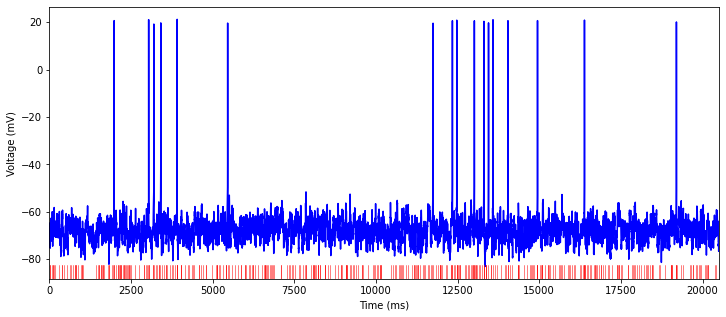

In [10]:
spktimes = tspk.as_numpy()
spktimes = spktimes[spktimes > tstart]
nspk = spktimes.size
firing_rate = nspk / tdur * 1000
print(f'Firing rate: {firing_rate:.4g} Hz')

plt.figure(figsize=(12, 5))
plt.plot(t, soma_v, 'b')
for x in tsyn:
    plt.axvline(x, 0., 0.05, color='r', linewidth=0.5)
plt.xlim([0, tstop])
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.show()